# Template-Based Models and Structured Conditional Distributions

<img style="float: center; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/f/f0/R%C3%A9seau_bay%C3%A9sien_3t.svg" width="800px" height="600px" />

> Often, we will find ourselves with applications that require us to model probability distributions that corresponds to a repetitive structure. In this session, we will study how to represent two types of such recurring structures:
  1. **Temporal models**, where we are interested in reasoning about some variables as they evolve over time;
  2. **Plate models**, where we are interested in modeling multiple entities whose properties are governed by the same model.
  
> On the other hand, we will explore other conditional probability distribution (CPD) representations, different from the tabular CPD that we have studied before, that will allow us to represent broader distribution classes.

> **Objectives:**
> - To learn what are template models;
> - To study how to model distribution of variables that evolve over time.
> - To describe additional CPD representations.

> **References:**
> 
> - Probabilistic Graphical Models: Principles and Techniques, By Daphne Koller and Nir Friedman. Chap. 5 - 6.
> - Probabilistic Graphical Models Specialization, offered through Coursera. Prof. Daphne Koller.
> - Mastering Probabilistic Graphical Models Using Python, By Ankur Ankan and Abinash Panda. Chap. 1.


<p style="text-align:right;"> Image from: https://upload.wikimedia.org/wikipedia/commons/f/f0/R%C3%A9seau_bay%C3%A9sien_3t.svg.</p>

___

# 1. Template models

## 1.1. Overview
In the last class, we studied Bayesian networks (BNs). We saw, among other things, that a Bayesian network specifies a joint distribution over a set of random variables (RVs) $X_1,\dots, X_n$. This can be applied in several scenarios, like medical diagnosis or credit worthiness evaluation. In these examples, the different situations to which the network is applied all share the same structure, but the values of the attributes differ accross subjects:
- In medical diagnosis: accross patients;
- in credit worthines: accross borrowers.

On the other hand, one may have much more complex spaces that relate to fixed set of RVs. One setting arises from thinking of phenomena that evolve over time, we would like to encode distributions over variables that are continuously changing. For example, one may be interested in tracking a vehicle (robot) location as it moves through certain field and gather some observations (location, speed, weather sensors).

Another complex setting arises in, for example, a Genetic desease risk evaluation. In this case, one has the family tree, with all individuals having their own properties. The probabilistic model then, should encode a joint distribution over the properties of all the family members. In this setting, we cannot define a unique BN that represents all the families universally, since each family tree is different. However, the underlying mechanism of passing genes from parents to childs is identical accross all the families in the world.

In this sense, the **template-based models** are an important extension of *the language* of probabilistic graphical models, which constitutes a general purpose representation that allow us to model multiple problems, using the *same exact model*.

**Example:** Genetic inheritance

In [1]:
from IPython.display import Image

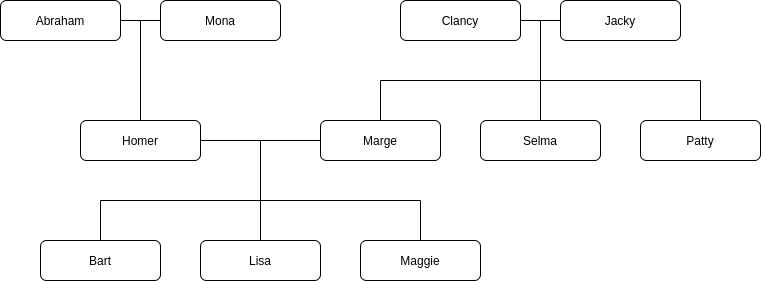

In [2]:
Image("figures/SimpsonPedigree.png")

<p style="text-align:right;"> Constructed from: https://simpsons.fandom.com/es/wiki/Familia_Simpson.</p>

One can use genetic information to predict the probability that a person will have a physical trait. Many human physiscal traits, such as freckles, hair color, and also many diseases are regulated by one or more proteins present in the DNA sequences.

Genetic inheritance patterns are often consistent from generation to generation, and template models are a natural way to model them, because the process how these patterns are inherited is the same accross all the families in the world.

If you don't remember much about high-school genetics, I recommend you to watch this [videos](https://www.khanacademy.org/science/high-school-biology/hs-classical-genetics/hs-introduction-to-heredity/v/introduction-to-heredity?playlist=Biology).

Given the above family tree, we can construct the following BN:

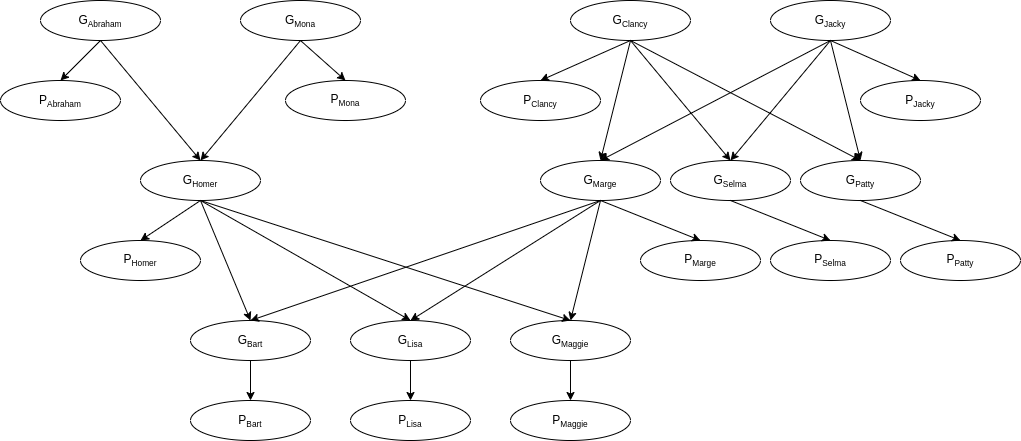

In [3]:
Image("figures/SimpsonBN.png")

where $G_{person}$ is the **genotype of person**, whereas $P_{person}$ is the **phenotype of person**.

If a family tree with different structure is given, then this model does not apply any more. However, we would still want to use the same sort of ideas we used to get this network, because there are a lot of things in common in the process of inheritance. This notion is known as **sharing between models**.

Additionally, we have also **sharing within the model**: relation between genotypes and phenotypes (for example: blood types, freckles, diseases).

So, we have a large amount of sharing of both: structure and parameters.

Then, we would like to have some way of constructing models that have this large amounts of shared structure that allows us to construct very large models from a sparse parametrization, and also to construct entire families of models from a concise representation.

**More examples:**

University:

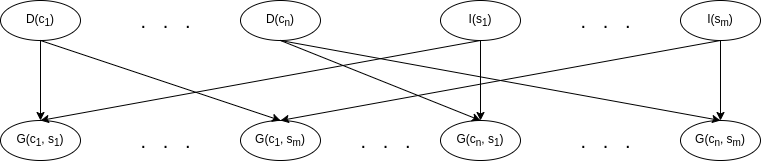

In [4]:
Image("figures/UniversityBN.png")

In the graph above, all the $G$(rade) variables have the same CPD.

As we mentioned before, another type of template-based structures are the temporal models.

Robot:

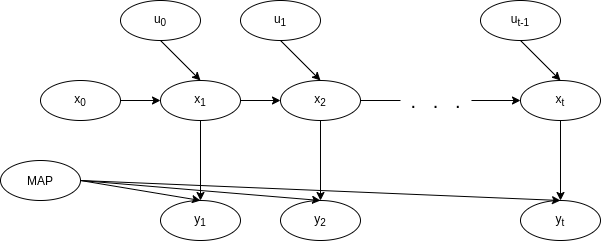

In [5]:
Image("figures/RobotBN.png")

Under the assumption of time invariance, the CPDs of $X_t$ and $Y_t$ for all $t$ are the same.

Let's look these models in more detail.

## 1.2. Temporal models: Dynamic Bayesian Networks

We focus on modeling dynamic settings, this is, systems that evolve over time.

To model such settings, we consider the **system state** whose value at time $t$ is a snapshot of the relevant variables of the system at time $t$.

- What do we mean when we say relevant variables? We mean that knowing the value of these variables at time $t$ and knowing the value of the inputs to the system for all time instants after $t$, is enough to know the value of these variables for all time instants after $t$.

We assume that the system state is represented by a set of RVs $\bar{X}=\{X_1, \dots X_n\}$. We use $X_i^{(t)}$ to represent the instantiation of $X_i$ at time $t$.

- Note that $X_i$ is not a variable that takes a value. It is a **template variable** which is instantiated at different points in time $t$, and each $X_i^{(t)}$ is a RV that takes values in $\mathrm{Val}(X_i)$.

Hence, we want to model distributions over trajectories of the system state.

To do this, we make the following assumptions:
- Discretize the continuous timeline into a set of *time slices* with predetermined granularity $\Delta$.
- $X_i^{(t)}$ represents the variable $X_i$ at time $t\Delta$, with $t=0,1,2,\dots$.
- $X_i^{(t:t')}=\{X_i^{(t)}, X_i^{(t+1)},\dots,X_i^{(t')}\}$.

With this assumpltions, what we want to do is to represent the distribution

$$P\left(\bar{X}^{(t:t')}\right)$$

for any $t,t'$.

In particular, for $t=0$ and $t'=T$, and using the chain rule appropriately:

$$P\left(\bar{X}^{(0:T)}\right)=P\left(\bar{X}^{(0)}\right)\prod_{t=0}^{T-1}P\left(\bar{X}^{(t+1)} | \bar{X}^{(0:t)}\right)$$

Now, we introduce the concept of state, through the well-known Markov assumption:

> *Definition.* We say that a dynamic system over the template variables $\bar{X}$ satisfies the **Markov assumption** if, for all $t\geq 0$,
>
> $$\left(\bar{X}^{(t+1)} \perp \bar{X}^{(0:t-1)} | \bar{X}^{(t)}\right).$$
>
> A system satisfying the Markov assumption is called a **Markovian system**.

We note that the Markov assumption is:
- a conditional idependence assumption,
- which reflects that knowing the system state at time $t$ is enough for knowing the system state for all time instants after $t$,
- this is, the information before $t$ does not provide any additional information.

Although it is a common assumption, one always has to evaluate if the Markov assumption is reasonable or not depending upon the particular application.

Using the Markov assumption:

$$P\left(\bar{X}^{(0:T)}\right)=P\left(\bar{X}^{(0)}\right)\prod_{t=0}^{T-1}P\left(\bar{X}^{(t+1)} | \bar{X}^{(t)}\right)$$

Note that although the right side of the above ecuation has been simplified enormously, it still leaves us with the task of acquiring an infinite set of conditional distributions $P\left(\bar{X}^{(t+1)} | \bar{X}^{(t)}\right)$.

To handle this, we often make the following additional assumption:

> *Definition.* We say that a Markovian dynamic system is **stationary**, or **time invariant** if the condistional distribution $P\left(\bar{X}^{(t+1)} | \bar{X}^{(t)}\right)$ is the same for all $t$. This is, for all $t\geq0$
>
> $$P\left(\bar{X}^{(t+1)} | \bar{X}^{(t)}\right) = P\left(\bar{X}' | \bar{X}\right).$$

Using the stationary assumption:

$$P\left(\bar{X}^{(0:T)}\right)=P\left(\bar{X}^{(0)}\right)\prod_{t=0}^{T-1}P\left(\bar{X}' | \bar{X}\right)$$

**Example.** Consider a model of a vehicle localization system:

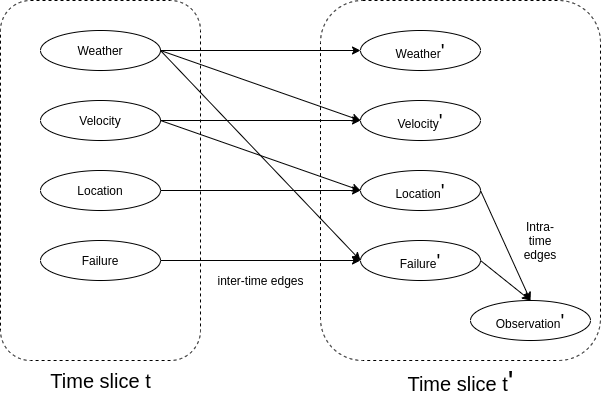

In [6]:
Image("figures/Vehicle2TBN.png")

This model represents the time-invariant CPD $P\left(\bar{X}' | \bar{X}\right)$, not the entire model.

Particularly, we have the following transition dynamics:

$$P(W', V', L', F', O' | W, V, L, F)=P(W'|W)P(V'|W,V)P(L'|V,L)P(F'|W,F)P(O'|L',F'),$$

and the factor $P(O'|L',F')$ means that the dynamics of sensor is fast.

The above representation defines the transition model and is known as 2-time-slice Bayesian network:

> *Definition.* A **2-time-slice Bayesian network (2-TBN)** for a dynamic system over $X_1,\dots,X_n$ is a conditional BN such that:
> - The nodes include $X_1',\dots,X_n'$ and a subset of $X_1,\dots,X_n$;
> - only the nodes $X_1',\dots,X_n'$ have parents, and therefore a CPD.

With the above, the 2-TBN defines a conditional distribution:

$$P\left(\bar{X}' | \bar{X}\right) = \prod_{i=1}^{n}P(X_i'|\mathrm{Pa}X_i').$$

To completely specify the trajectory distribution $P\left(\bar{X}^{(0:T)}\right)$, we still have to spcefify the initial state distribution $P\left(\bar{X}^{(0)}\right)$.

In the vehicle example:

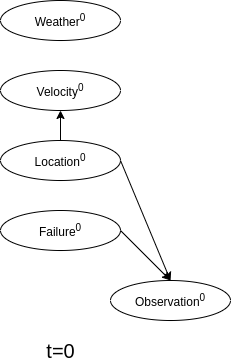

In [7]:
Image("figures/Vehicle0.png")

$$P(W^{(0)}, V^{(0)}, L^{(0)}, F^{(0)}, O^{(0)})=P(W^{(0)}) P(V^{(0)} | L^{(0)}) P(L^{(0)}) P(F^{(0)}) P(O^{(0)}|L^{(0)}, F^{(0)})$$

Finally, we are ready to define the concept of dynamic Bayesian network.

> *Definition.* A **dynamic Bayesian network (DBN)** is a pair $(\mathcal{B}_0, \mathcal{B}_{\to})$, where:
> - $\mathcal{B}_0$ is a BN over $\bar{X}^{0}$, and represents the initial state distribution;
> - $\mathcal{B}_\to$ is a 2-TBN over $\bar{X}$, and represents the transition dynamics.

Given a DBN and some $T>0$, one can always "unroll" the network for representing a trajectory $\bar{X}^{(0:T)}$, that satisfies:
- The dependency model and CPDs for $\bar{X}^{0}$, are copied from $\mathcal{B}_0$;
- The dependency model and CPDs for $\bar{X}^{(t)}$ for all $t>0$, are copied from $\mathcal{B}_\to$.

This is called the **ground network**. Through this concept, we can see that a DBN is a compact representation of (possibly) infinite set of BN.

## 1.3. Temporal models: Hidden Markov Models

The **Hidden Markov Models (HMM)** are important special subclass of DBNs. What makes them important is that they have their own type of structure that makes them particularly useful.

We consider the simplest case, through the following single state 2-TBN:

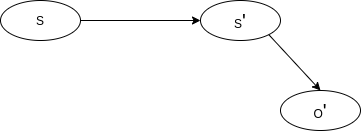

In [8]:
Image("figures/SingleStateHMM.png")

The interesting thing about HMMs is that they have their own internal structure that manifests notably in the transition model:

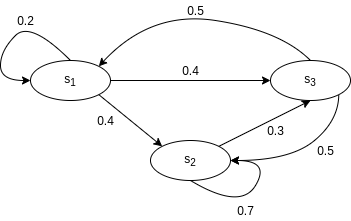

In [9]:
Image("figures/HMM.png")

In this network, nodes are not RVs but particular assignments to the state variable $S$. This structure can be summarized into a transition matrix $P(s'|s)$, that tells us that:

- $P(s_2|s_1) = 0.4$;
- $P(s_1|s_3) = 0.5$.

## 1.4. Plate models

Having studied dynamical systems, it's time to turn our attention to other class of template-based representation: **plate models**.

This repeated structure representation occurs when we have multiple objects of the same type. In this setting we have objects of the same type which share the same probabilistic model.

The most simple case, may be repetitive coin tosses:

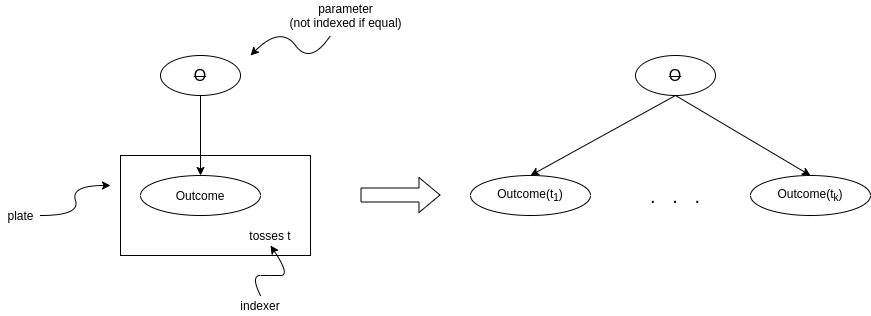

In [10]:
Image("figures/SamplePlate.png")

- where $t\in\{t_1, \dots, t_k\}$ is the set of tosses,
- $\theta$ are the parameters of the CPD: these are not always put explicitly in the model, but is a convenient thing to do when studying learning.

**Example:** Now, let's revisit the student example considering only the variables $I$(ntelligence of the student), $D$(ifficulty of the course) and $G$(rade).

If we only consider one course, we may have:

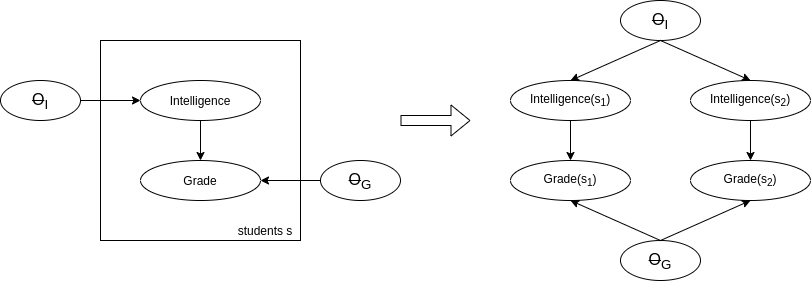

In [11]:
Image("figures/Student1.png")

*Nested plates:* If we now have several courses

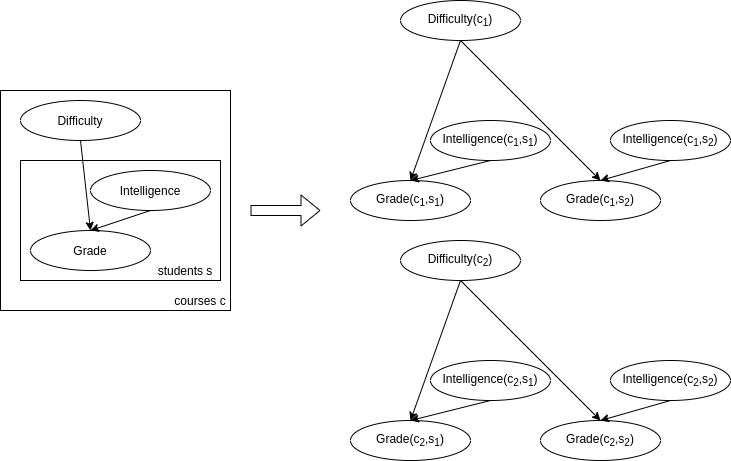

In [12]:
Image("figures/Student2.png")

Here, the Intelligence of the student $s$ in the course $c$ affects the Grade of the student in the course c, as well as the Difficulty of the course c.

This implies that there is a specific intellicence for every student in every course. This may or may not be what we want.

*Overlaping plates:* If we want the intelligence to be the same over all courses:

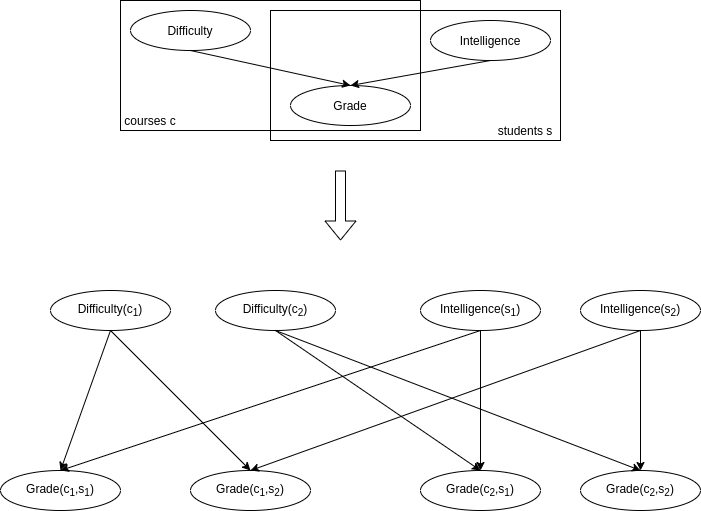

In [13]:
Image("figures/Student3.png")

**Collective inference.** This repeated models give rise to a new kind of reasoning pattern called collective inference.

For example:

1. Imagine a single student in two courses:
   - In one course the student got a high grade;
   - whereas in the other course the student got a bad grade.
   Here, we can say nothing about the intelligence of the student.
   
2. However, if we have several students taking several courses, then we might come up with more info. Consider the case with four students and one course:
   - Three students got a high grade and one got a normal grade.
   - Then we can infer that the course is easy, and the student that got a normal grade is not that intelligent.
   
**See the SAMIAM network**.

___
# 2. Structured CPDs

We have focused in the global structure of the distribution so far. Based on the global independece properties of the distribution, we are allowed to factorize a high-dimensional joint distribution into a product of lower-dimensional factors (CPDs).

We will analyze other CPDs' structures in more detail, which may become important when facing real-world applications.

## 2.1. Tabular representations

If our problem consists of discrete RVs only, the we can always work with tabular CPDs of the form $P(X | \mathrm{Pa}X)$, which contains an entry for each joint assignment of $X$ and $\mathrm{Pa} X$.

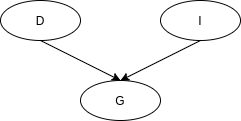

In [15]:
Image("figures/Toy.png")

|           | $g^0$ | $g^1$ | $g^2$ |
| --------- | ----- | ----- | ----- |
| $i^0,d^0$ | 0.3   | 0.4   | 0.3   |
| $i^0,d^1$ | 0.05  | 0.25  | 0.7   |
| $i^1,d^0$ | 0.9   | 0.08  | 0.02  |
| $i^1,d^1$ | 0.5   | 0.3   | 0.2   |

The unique constraints for this table to be a proper CPD is that its entry are nonnegative, and

$$\sum_{x\in\mathrm{Val}(x)} P(X=x | \mathrm{Pa}X) = 1.$$

In this sense, table CPDs are a general representation in the discrete setting, since every possible CPD can be represented using a table. On the other hand, we will use the tabular CPDs naturally when analyzing inference algorithms.

On the other hand, assume that we are working on a medical diagnosis system, which have a variable related to Cough. This particular symptom has a lot of different causes:

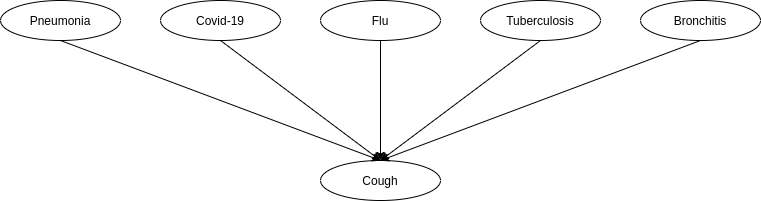

In [16]:
Image("figures/Cough.png")

Hence, we realize that this variable (Cough) has $k$ parents which we assume to be binary. Then, the number of entries that this CPD has is $2^k$ (exponential).

To see the problem, imagine that it has only $10$ parents, then we would have to elicit/learn

$$2^{10}=1024$$

parameters to completely specify this CPD.

Fortunately, nothing imposes us a table CPD.

## 2.2. General CPD 

A CPD $P(X|Y_1,\dots, Y_k)$ specifies a distribution over $X$ for each assignment $y_1, \dots, y_k$. Thus, we can use any function to specify a factor $\phi(X,Y_1,\dots,Y_k)$ such that

$$\sum_X \phi(X,y_1,\dots,y_k)=1,$$

for all $y_1,\dots,y_k$.

Before looking at particular CPD structures, let's define a type of independence that only holds for particular values of some variables.

> *Definition.* We say that $\bar{X}$ and $\bar{Y}$ are contextually independent given $\bar{Z}$ and the context $\bar{c}$, denoted by $(\bar{X} \perp_c \bar{Y} | \bar{Z}, \bar{c})$, if
>
> $$P(\bar{X} | \bar{Y}, \bar{Z}, \bar{c}) = P(\bar{X} | \bar{Z}, \bar{c}).$$

**Example.** Which of the following context-specific independencies hold when $X=\mathrm{OR}(Y_1, Y_2)$?

| $Y_1$   | $Y_2$   | $X$     | $P$  |
| ------- | ------- | ------- | ---- |
| $y_1^0$ | $y_2^0$ | $x^0$   | 0.25 |
| $y_1^0$ | $y_2^1$ | $x^1$   | 0.25 |
| $y_1^1$ | $y_2^0$ | $x^1$   | 0.25 |
| $y_1^1$ | $y_2^1$ | $x^1$   | 0.25 |

1. $(X \perp_c Y_1 | y_2^0)$
1. <font color=green> $(X \perp_c Y_1 | y_2^1)$ </font>
1. <font color=green> $(Y_1 \perp_c Y_2 | x^0)$ </font>
1. $(Y_1 \perp_c Y_2 | x^1)$

## 2.3. Tree CPD

One class of structured CPDs that is most useful is the class of CPDs that encodes a dependence of the child on a parten in certain contexts.

**Example.** Consider the case when the student is applying for a job. The job recruiter only takes into account the Recommendation letter and the Qualification in the state exam.

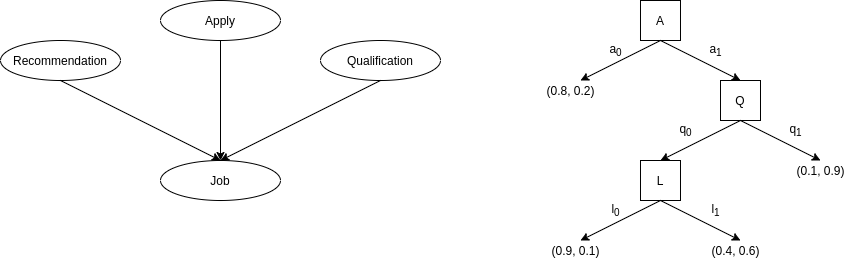

In [17]:
Image("figures/TreeCPD.png")

Which of the following context-specific independencies are implied by the tree structure?

1. <font color=green> $(J \perp_c L | A, q^1)$ </font>
1. <font color=green> $(J \perp_c L | a^1, q^1)$ </font>
1. <font color=green> $(J \perp_c L,Q | a^0)$ </font>
1. $(J \perp_c L | a^1)$

However, it can be shown that tree CPDs can also be formulated as tabular CPDs.

# Announcements

## 1. Read sections 5.4 (Independence of causal influence) and 5.5 (Continuous variables) of the book.
## 2. No homework this time. 
## 3. Quiz the next class.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>